# Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

**Этапы выполнения проекта:**

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучие разных моделей с различными гиперпараметрами. Создание тестовой выборки размером 10% от исходных данных.
4. Проверка данных на тестовой выборке и выводы.

Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor, Pool, cv
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
import matplotlib.pyplot as plt

taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [2]:
taxi.sort_index(inplace=True)
# ресемплирование по 1 часу
taxi = taxi.resample('1H').sum() 

In [3]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные загружены и ресемплированы по 1 часу. Далее приступим к анализу.

# 2. Анализ

In [4]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [5]:
# Изучим сезонность
taxi2 = taxi.resample('1D').sum()
decomposed = seasonal_decompose(taxi2)

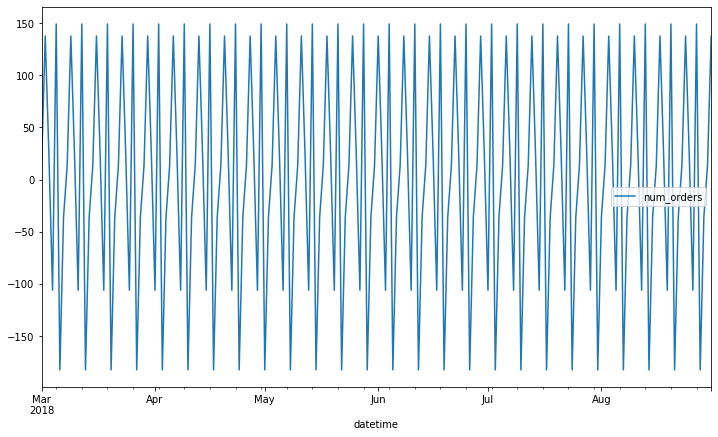

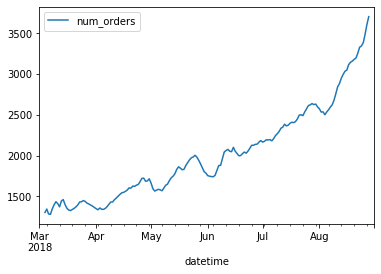

In [6]:
decomposed.seasonal.plot(figsize=(12,7))
decomposed.trend.plot()

От месяца к месяцу наблюдается тренд увеличения числа поездок. Возможно это связано с сезоном отпусков, который начинается летом и продолжается до октября, также возможен рост компании и ее популярности. Сезонность проявляется каждую неделю.  

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Исследование - понятно. Не хватает, к сожалению, твоих выводов о сезонности, тренде((( <br>
    
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - очень нужный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это очень помогает сделать предвариетльные выводы<br>
    
Хочу озвучить ещё такой момент<br>
Дело в том, в реальности бизнеса есть все три вида сезонности:<br>
1)дневная сезонность есть - ведь данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2)Но ведь есть ещё внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером (об этом Вы сказали) <br>
3)Ну и наконец есть месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных (и Вы об этом пишите) восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>
Поэтому, я бы дал такой совет:<br>
на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>
Ну, а если вернуться к постановке задаче - построить прогноз на час (очень маленький горизонт), то двух сезонности может и хватить.

# 3. Обучение

In [8]:
# Функция создает признаки: календарные признаки, отстаюшие значения и скользящее среднее
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [9]:
make_features(taxi, 24, 10)

In [10]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

In [11]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

In [12]:
model = LinearRegression()
model.fit(train_features, train_target)
predict_train = model.predict(test_features)
rmse = mean_squared_error(test_target, predict_train) ** 0.5
rmse

45.17810654807807

In [13]:
#Обучим модель градиентного бустинга из catboost применив кросс-валидацию
cv_taxi = Pool(data=train_features,
              label=train_target)

In [14]:
#Параметры модели
params = {'iterations': 1000,
         'depth': 6,
         'loss_function': 'RMSE',
          'learning_rate': 0.1,
         'verbose': 20,
         'random_state': 12345}

In [98]:
cv(cv_taxi, params, fold_count=3, plot=False, as_pandas=True)

0:	learn: 80.3924533	test: 80.4433220	best: 80.4433220 (0)	total: 477ms	remaining: 7m 56s
20:	learn: 27.0339662	test: 27.9047707	best: 27.9047707 (20)	total: 5.92s	remaining: 4m 36s
40:	learn: 22.4732157	test: 24.2354127	best: 24.2354127 (40)	total: 8.96s	remaining: 3m 29s
60:	learn: 21.1392971	test: 23.6329305	best: 23.6329305 (60)	total: 11.3s	remaining: 2m 53s
80:	learn: 20.1460275	test: 23.2733399	best: 23.2733399 (80)	total: 13.4s	remaining: 2m 31s
100:	learn: 19.2776305	test: 23.0261868	best: 23.0261868 (100)	total: 16.2s	remaining: 2m 24s
120:	learn: 18.2784460	test: 22.8152701	best: 22.8152701 (120)	total: 18.5s	remaining: 2m 14s
140:	learn: 17.2485321	test: 22.6132314	best: 22.6132314 (140)	total: 20.7s	remaining: 2m 6s
160:	learn: 16.4673937	test: 22.5488591	best: 22.5426741 (158)	total: 23.1s	remaining: 2m
180:	learn: 15.7653975	test: 22.5032818	best: 22.4997433 (175)	total: 25.3s	remaining: 1m 54s
200:	learn: 15.1133057	test: 22.4733051	best: 22.4733051 (200)	total: 27.8s	r

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,80.443322,0.546121,80.392453,0.390262
1,1,73.879297,0.468564,73.813585,0.362481
2,2,68.259655,0.474933,68.140722,0.368040
3,3,63.004156,0.562607,62.832655,0.293460
4,4,58.390536,0.652788,58.137041,0.421397
...,...,...,...,...,...
995,995,22.534705,0.556339,4.437425,0.101405
996,996,22.534109,0.554006,4.428494,0.101742
997,997,22.534337,0.553977,4.423162,0.104134
998,998,22.531837,0.553603,4.414805,0.105092


In [15]:
params2 = {'iterations': 1000,
         'depth': 12,
         'loss_function': 'RMSE',
          'learning_rate': 0.1,
         'verbose': 20,
         'random_state': 12345}

In [100]:
cv(cv_taxi, params2, fold_count=3, plot=False, as_pandas=True)

0:	learn: 80.8474268	test: 81.0746916	best: 81.0746916 (0)	total: 1.94s	remaining: 32m 21s
20:	learn: 26.5656740	test: 30.4226424	best: 30.4226424 (20)	total: 37.9s	remaining: 29m 28s
40:	learn: 18.1573743	test: 25.3226013	best: 25.3226013 (40)	total: 1m 14s	remaining: 29m 7s
60:	learn: 14.6626318	test: 24.2846091	best: 24.2846091 (60)	total: 1m 52s	remaining: 28m 45s
80:	learn: 12.3971513	test: 23.8735136	best: 23.8735136 (80)	total: 2m 29s	remaining: 28m 21s
100:	learn: 10.7458792	test: 23.6984179	best: 23.6984179 (100)	total: 3m 6s	remaining: 27m 43s
120:	learn: 9.0480100	test: 23.5689547	best: 23.5689547 (120)	total: 3m 44s	remaining: 27m 11s
140:	learn: 7.5808122	test: 23.4956325	best: 23.4956325 (140)	total: 4m 22s	remaining: 26m 40s
160:	learn: 6.2985369	test: 23.4070907	best: 23.4070907 (160)	total: 5m	remaining: 26m 8s
180:	learn: 5.3617061	test: 23.3814934	best: 23.3814934 (180)	total: 5m 38s	remaining: 25m 32s
200:	learn: 4.5365580	test: 23.3644142	best: 23.3637566 (198)	tot

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,81.074692,0.976199,80.847427,0.101325
1,1,75.352784,0.853450,74.935275,0.232332
2,2,69.692198,0.955473,69.117529,0.044719
3,3,65.256101,1.024363,64.444909,0.167730
4,4,61.162772,1.512418,60.130731,0.524643
...,...,...,...,...,...
995,995,23.315584,0.720147,0.019615,0.002488
996,996,23.315581,0.720148,0.019456,0.002492
997,997,23.315584,0.720158,0.019358,0.002521
998,998,23.315586,0.720169,0.019251,0.002587


Лучшие параметры для catboost: depth=6, iterations=310.

In [16]:
# Обучим модель из LightGBM тоже применив кросс-валидацию
lgb_params = {'metric': 'rmse',
              'objective': 'regression',
             'num_boost_round': 1500,
             'stratified': False,
             'random_state': 12345,
             'max_depth': 12,
             'learning_rate': 0.1}

In [17]:
lgb_train = lgb.Dataset(train_features, train_target)

In [18]:
lgb.cv(lgb_params, lgb_train, verbose_eval=20, stratified=False)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:503: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	cv_agg's rmse: 23.6372 + 0.301764
[40]	cv_agg's rmse: 22.6548 + 0.424461
[60]	cv_agg's rmse: 22.4461 + 0.485605
[80]	cv_agg's rmse: 22.4262 + 0.494045
[100]	cv_agg's rmse: 22.4142 + 0.52541
[120]	cv_agg's rmse: 22.4125 + 0.547917
[140]	cv_agg's rmse: 22.4016 + 0.538621
[160]	cv_agg's rmse: 22.4104 + 0.550133
[180]	cv_agg's rmse: 22.4183 + 0.547987
[200]	cv_agg's rmse: 22.4433 + 0.546705
[220]	cv_agg's rmse: 22.4594 + 0.529942
[240]	cv_agg's rmse: 22.4797 + 0.540022
[260]	cv_agg's rmse: 22.4809 + 0.539203
[280]	cv_agg's rmse: 22.5027 + 0.533952
[300]	cv_agg's rmse: 22.5106 + 0.539848
[320]	cv_agg's rmse: 22.5421 + 0.539684
[340]	cv_agg's rmse: 22.5526 + 0.52612
[360]	cv_agg's rmse: 22.5588 + 0.539836
[380]	cv_agg's rmse: 22.5618 + 0.530637
[400]	cv_agg's rmse: 22.5815 + 0.525933
[420]	cv_agg's rmse: 22.5931 + 0.526384
[440]	cv_agg's rmse: 22.6066 + 0.529345
[460]	cv_agg's rmse: 22.6169 + 0.526493
[480]	cv_agg's rmse: 22.6261 + 0.525513
[500]	cv_agg's rmse: 22.6342 + 0.527101
[520]	

{'rmse-mean': [36.51533068692824,
  34.64828594163738,
  32.994285597536056,
  31.59710842627671,
  30.360352883517663,
  29.29980004114637,
  28.370767468124114,
  27.60187715853102,
  26.916244062415934,
  26.334361154231182,
  25.852884388356436,
  25.45232252606457,
  25.051057419106186,
  24.76500501152342,
  24.500777661905452,
  24.286951139357214,
  24.06304100375799,
  23.925603885411597,
  23.770228131725904,
  23.637229586014037,
  23.551363584581456,
  23.44075367208969,
  23.332478625156114,
  23.25651648275514,
  23.21368229304239,
  23.158011544945087,
  23.108542965227063,
  23.054993509564802,
  22.994538226791853,
  22.9690280947786,
  22.899091510124,
  22.854703343415295,
  22.81913371115295,
  22.801720332003594,
  22.782874569965678,
  22.730961180734532,
  22.697231012893603,
  22.678236335044808,
  22.65345537140804,
  22.65482669834249,
  22.640572623463584,
  22.620725452537666,
  22.594949951598117,
  22.584952174867325,
  22.585584795377578,
  22.57013095984

In [19]:
lgb_params2 = {'metric': 'rmse',
              'objective': 'regression',
             'num_boost_round': 2000,
             'stratified': False,
             'random_state': 12345,
             'max_depth': 6}

In [20]:
lgb.cv(lgb_params2, lgb_train, verbose_eval=20, stratified=False)

[20]	cv_agg's rmse: 23.7097 + 0.284832
[40]	cv_agg's rmse: 22.7591 + 0.379765
[60]	cv_agg's rmse: 22.5342 + 0.397732
[80]	cv_agg's rmse: 22.4699 + 0.397911
[100]	cv_agg's rmse: 22.436 + 0.415416
[120]	cv_agg's rmse: 22.4435 + 0.393352
[140]	cv_agg's rmse: 22.4811 + 0.389939
[160]	cv_agg's rmse: 22.4867 + 0.386004
[180]	cv_agg's rmse: 22.4718 + 0.386158
[200]	cv_agg's rmse: 22.4833 + 0.383742
[220]	cv_agg's rmse: 22.5003 + 0.370339
[240]	cv_agg's rmse: 22.5117 + 0.365606
[260]	cv_agg's rmse: 22.5131 + 0.386042
[280]	cv_agg's rmse: 22.5347 + 0.398828
[300]	cv_agg's rmse: 22.5501 + 0.405069
[320]	cv_agg's rmse: 22.5451 + 0.417801
[340]	cv_agg's rmse: 22.5651 + 0.419156
[360]	cv_agg's rmse: 22.5762 + 0.425666
[380]	cv_agg's rmse: 22.6053 + 0.409722
[400]	cv_agg's rmse: 22.6308 + 0.401947
[420]	cv_agg's rmse: 22.6408 + 0.388321
[440]	cv_agg's rmse: 22.6547 + 0.383417
[460]	cv_agg's rmse: 22.674 + 0.382257
[480]	cv_agg's rmse: 22.6856 + 0.380152
[500]	cv_agg's rmse: 22.7029 + 0.372854
[520]	

{'rmse-mean': [36.51177044095601,
  34.64640338306437,
  32.98317777225237,
  31.616899699833386,
  30.3840656175447,
  29.313416471544326,
  28.378515293176452,
  27.597668548518197,
  26.94319976336995,
  26.372594799814873,
  25.896193579372834,
  25.48798146792837,
  25.11799552025085,
  24.82668086359601,
  24.544706667248473,
  24.31782598603605,
  24.11304994401145,
  23.94664471797567,
  23.805194310167582,
  23.70973727088236,
  23.605954237914208,
  23.49973761775225,
  23.424284179623104,
  23.3565517940879,
  23.30600604502775,
  23.220097227359606,
  23.18316964133264,
  23.143353578012682,
  23.099882085369956,
  23.04566840462649,
  23.016713704399276,
  22.97074586756789,
  22.93631645088516,
  22.91770523175808,
  22.873489718106594,
  22.857936935365768,
  22.835391740964063,
  22.788501303034625,
  22.77828958044795,
  22.75908742863961,
  22.75523009509282,
  22.747035088134,
  22.723465936725173,
  22.700404118833358,
  22.67940899686943,
  22.672149945183314,
  22

Лучшая метрика получилась у catboost (rmse=22.4) с параметрами: depth=6, iterations=310. Эту модель и будем тестировать.

# 4. Тестирование

In [21]:
model_catboost = CatBoostRegressor(iterations=310,
         depth=6,
         loss_function='RMSE',
          learning_rate=0.1,
         verbose=20,
         random_state=12345)

In [22]:
model_catboost.fit(cv_taxi)

0:	learn: 36.9350857	total: 51.8ms	remaining: 16s
20:	learn: 24.1405192	total: 758ms	remaining: 10.4s
40:	learn: 22.3784481	total: 1.44s	remaining: 9.46s
60:	learn: 21.2946740	total: 2.03s	remaining: 8.3s
80:	learn: 20.3369449	total: 2.72s	remaining: 7.69s
100:	learn: 19.5807227	total: 3.31s	remaining: 6.86s
120:	learn: 18.8838499	total: 3.9s	remaining: 6.1s
140:	learn: 18.1067093	total: 4.5s	remaining: 5.39s
160:	learn: 17.5290458	total: 5.08s	remaining: 4.71s
180:	learn: 16.9279413	total: 5.68s	remaining: 4.05s
200:	learn: 16.3519773	total: 6.27s	remaining: 3.4s
220:	learn: 15.8124499	total: 6.86s	remaining: 2.76s
240:	learn: 15.4092002	total: 7.46s	remaining: 2.14s
260:	learn: 14.9697943	total: 8.14s	remaining: 1.53s
280:	learn: 14.5931425	total: 8.74s	remaining: 902ms
300:	learn: 14.2449782	total: 9.43s	remaining: 282ms
309:	learn: 14.0857369	total: 9.63s	remaining: 0us


In [23]:
pool_test = Pool(data=test_features, label=test_target)

In [24]:
predict = model_catboost.predict(pool_test)
rmse_cat = mean_squared_error(test_target, predict)**.5
rmse_cat

40.69681858723279

In [30]:
# Преобразуем предсказания в объект Series, чтобы построить сравнительный график факт/предсказание
predict_series = pd.Series(predict, index=test_target.index)
predict_series

datetime
2018-08-13 14:00:00     91.587144
2018-08-13 15:00:00    111.474017
2018-08-13 16:00:00    139.054411
2018-08-13 17:00:00    152.084058
2018-08-13 18:00:00    133.890217
                          ...    
2018-08-31 19:00:00    139.685456
2018-08-31 20:00:00    156.445017
2018-08-31 21:00:00    178.712171
2018-08-31 22:00:00    159.417905
2018-08-31 23:00:00    173.278778
Freq: H, Length: 442, dtype: float64

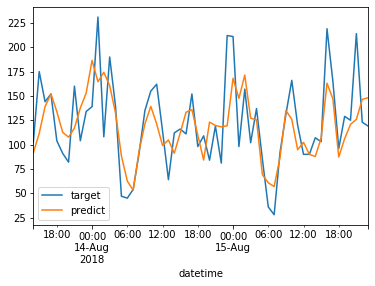

In [34]:
# График фактического значения целевого признака и прогноза
# для наглядности взят промежуток в несколько дней
test_target['2018-08-01':'2018-08-15'].plot(legend=True, label='target')
predict_series['2018-08-01':'2018-08-15'].plot(legend=True, label='predict')
plt.show()

### Вывод

Модель CatBoostRegressor справилась со своей задачей. Полученная метрика rmse = 40.7 меньше 48.
Из графика факт/предсказание видно, что модель усредняет значения целевого признака, на высоких пиках и глубоких ямах видна заметная разница в значениях.  